In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Load the dataset
file_path = 'tsla.csv'
data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Display the first few rows of the dataset and the data types of each column
print(data.head())
print(data.dtypes)


                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


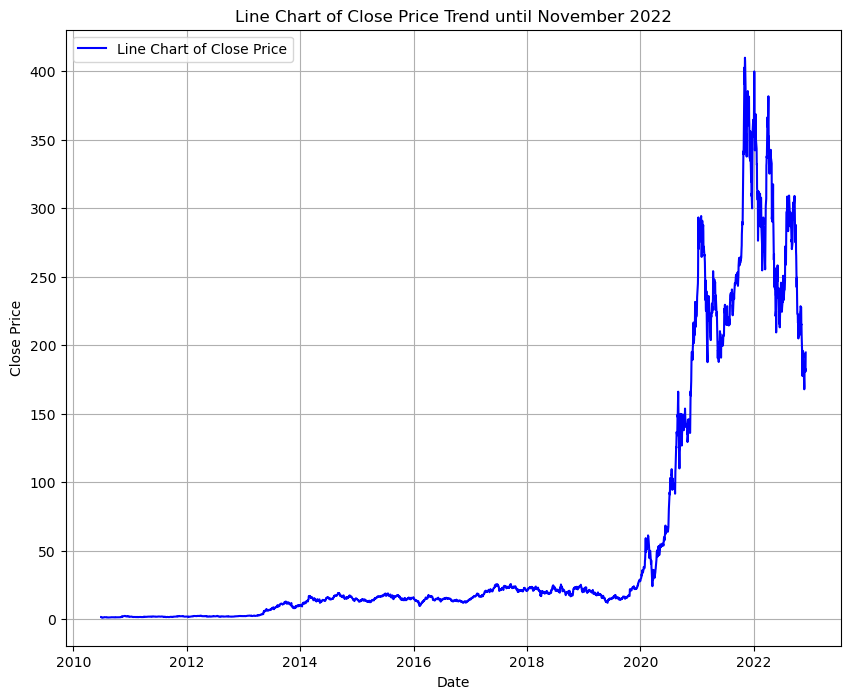

In [37]:
# Filter the data to show from start till "30-11-22"
filtered_data = data[:'2022-11-30']

# Plotting the filtered data as a line chart
plt.figure(figsize=(10, 8))
plt.plot(filtered_data['Close'], label='Line Chart of Close Price', color='blue')
plt.title('Line Chart of Close Price Trend until November 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


# LSTM Model

In [44]:
# Scaling the data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare the training and validation data for LSTM
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # Include the last 60 days of training data for context

# Create sequences for training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the data to be suitable for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Predicting 1 value

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))


C:\Users\zains\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 2.8601e-04 - val_loss: 0.0029
Epoch 2/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.9178e-05 - val_loss: 0.0025
Epoch 3/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 1.9256e-05 - val_loss: 0.0041
Epoch 4/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.6628e-05 - val_loss: 0.0022
Epoch 5/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.1412e-05 - val_loss: 0.0021
Epoch 6/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.3101e-05 - val_loss: 0.0030
Epoch 7/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.4275e-05 - val_loss: 0.0016
Epoch 8/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.1301e-06 - val_loss: 0.0020
Epoch 9/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.2619e-05 - val_loss: 0.0014
Epoch 10/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 9.7729e-06 - val_loss: 0.0026
Epoch 11/150
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 9.0376e-06 - val_loss: 0.0020
Epoch 12

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


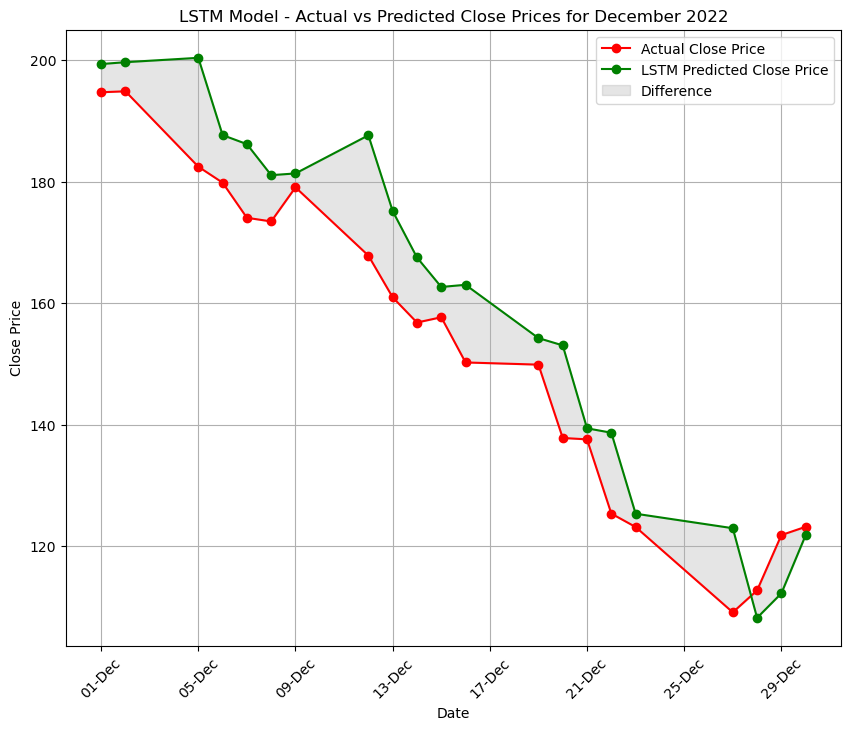

In [45]:
# Make predictions on the test data
predicted_scaled = model.predict(X_test)

# Inverse transform to get the actual values
predicted = scaler.inverse_transform(predicted_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Filter the data for December 2022 only
december_start = '2022-12-01'
december_end = '2022-12-30'
december_mask = (data.index >= december_start) & (data.index <= december_end)

# Filter the actual and predicted values for December 2022
december_dates = data.index[december_mask]
predicted_december = predicted[-len(december_dates):]
y_test_december = y_test_actual[-len(december_dates):]

# Plotting the LSTM predictions vs actual values for December 2022
plt.figure(figsize=(10, 8))
plt.plot(december_dates, y_test_december, label='Actual Close Price', color='red', marker='o')
plt.plot(december_dates, predicted_december, label='LSTM Predicted Close Price', color='green', marker='o')
plt.title('LSTM Model - Actual vs Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

# Fill between for a clearer comparison
plt.fill_between(december_dates, y_test_december.flatten(), predicted_december.flatten(), 
                 color='gray', alpha=0.2, label='Difference')

plt.legend()
plt.grid(True)
plt.show()

In [47]:
# # Make predictions on the test data using LSTM model
# predicted_scaled = model.predict(X_test)

# # Inverse transform to get the actual values
# predicted_lstm = scaler.inverse_transform(predicted_scaled)
# y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


# ARIMA Model

In [55]:
# Fit the ARIMA model
arima_model = ARIMA(data['Close'], order=(5, 1, 0))    #   autoregressive terms (AR), 1 differencing term (I), and 0 moving average terms (MA)
arima_model_fit = arima_model.fit()

# Create a future dataframe for December 2022 for ARIMA
start = '2022-12-01'
end = '2022-12-30'
arima_forecast = arima_model_fit.predict(start=start, end=end, dynamic=False)


C:\Users\zains\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zains\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zains\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


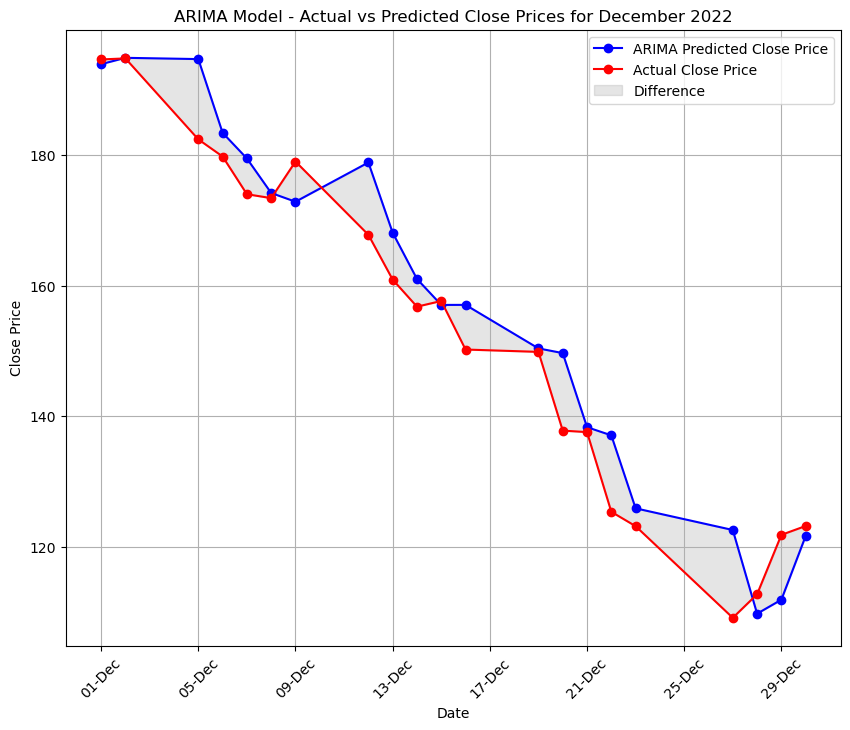

In [56]:
# Plotting the ARIMA predictions vs actual values for December 2022
plt.figure(figsize=(10, 8))
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Predicted Close Price', color='blue', marker='o')
plt.plot(december_dates, data['Close'][december_mask], label='Actual Close Price', color='red', marker='o')
plt.title('ARIMA Model - Actual vs Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

# Fill between for a clearer comparison
plt.fill_between(arima_forecast.index, data['Close'][december_mask], arima_forecast, 
                 color='gray', alpha=0.2, label='Difference')

plt.legend()
plt.grid(True)
plt.show()


# Prophet Model

In [57]:
# Prepare the data for Prophet
prophet_data = data.reset_index()[['Date', 'Close']]
prophet_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Fit the Prophet model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_data)

# Create a future dataframe for December 2022
future_dates = prophet_model.make_future_dataframe(periods=0, freq='D')
future_dates = future_dates[future_dates['ds'] >= december_start]  # Filter dates starting from December 1, 2022

# Forecast the future
forecast = prophet_model.predict(future_dates)

# Ensure the length of forecast matches the actual data for December
december_actual = data['Close'][december_mask][:len(forecast)]


12:29:23 - cmdstanpy - INFO - Chain [1] start processing
12:29:24 - cmdstanpy - INFO - Chain [1] done processing


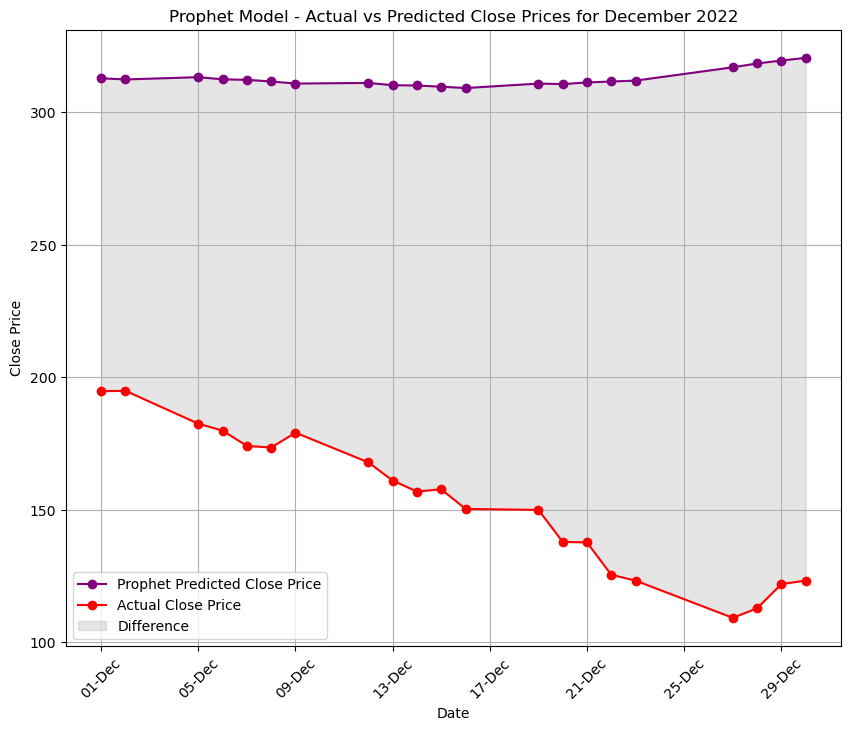

In [51]:
# Plotting the Prophet predictions vs actual values for December 2022
plt.figure(figsize=(10, 8))
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Predicted Close Price', color='purple', marker='o')
plt.plot(december_actual.index, december_actual, label='Actual Close Price', color='red', marker='o')
plt.title('Prophet Model - Actual vs Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

# Fill between for a clearer comparison
plt.fill_between(forecast['ds'], december_actual, forecast['yhat'], 
                 color='gray', alpha=0.2, label='Difference')

plt.legend()
plt.grid(True)
plt.show()

# Comparison of Actual and Predicted Values

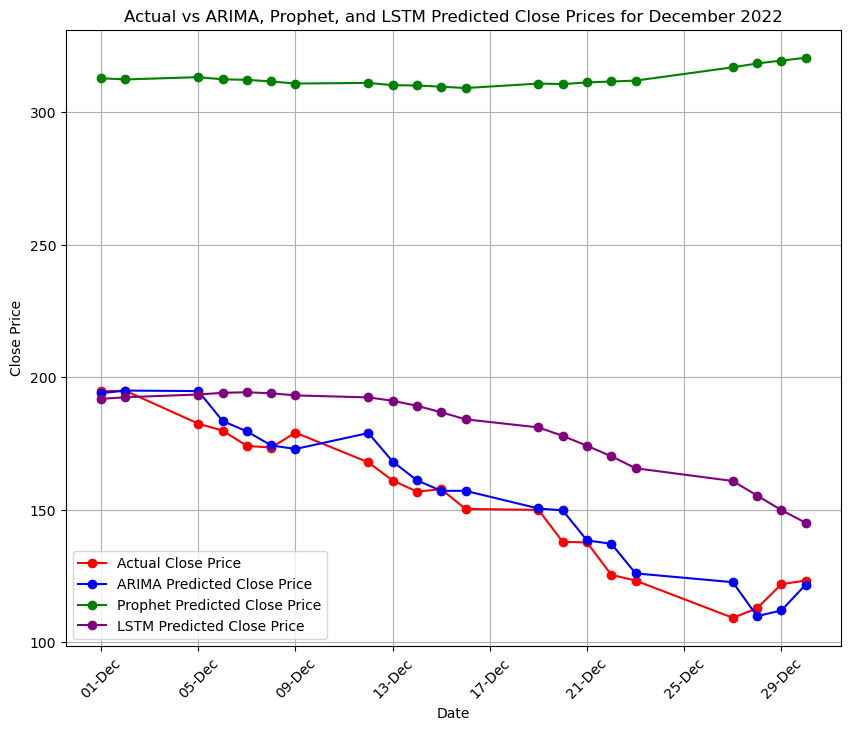

In [52]:
# Merge actual, ARIMA, and Prophet predictions for December 2022
combined_df = actual_dec_2022[['Close']].join(arima_forecast.rename('ARIMA'), how='inner').join(
    forecast.set_index('ds')[['yhat']].rename(columns={'yhat': 'Prophet'}))

# Adding LSTM predictions to the combined DataFrame
combined_df['LSTM'] = predicted_lstm_december

# Plotting the combined data
plt.figure(figsize=(10, 8))
plt.plot(combined_df.index, combined_df['Close'], label='Actual Close Price', color='red', marker='o')
plt.plot(combined_df.index, combined_df['ARIMA'], label='ARIMA Predicted Close Price', color='blue', marker='o')
plt.plot(combined_df.index, combined_df['Prophet'], label='Prophet Predicted Close Price', color='green', marker='o')
plt.plot(combined_df.index, combined_df['LSTM'], label='LSTM Predicted Close Price', color='purple', marker='o')
plt.title('Actual vs ARIMA, Prophet, and LSTM Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

plt.legend()
plt.grid(True)
plt.show()


In [35]:
# Calculate and display error metrics for LSTM model for December 2022
mse_lstm = mean_squared_error(actual_dec_2022['Close'], combined_df['LSTM'])
mae_lstm = mean_absolute_error(actual_dec_2022['Close'], combined_df['LSTM'])

print(f'LSTM Mean Squared Error for December 2022: {mse_lstm}')
print(f'LSTM Mean Absolute Error for December 2022: {mae_lstm}')

# Calculate and display error metrics for ARIMA model for December 2022
mse_arima = mean_squared_error(actual_dec_2022['Close'], combined_df['ARIMA'])
mae_arima = mean_absolute_error(actual_dec_2022['Close'], combined_df['ARIMA'])

print(f'ARIMA Mean Squared Error for December 2022: {mse_arima}')
print(f'ARIMA Mean Absolute Error for December 2022: {mae_arima}')

# Calculate and display error metrics for Prophet model for December 2022
mse_prophet = mean_squared_error(actual_dec_2022['Close'], combined_df['Prophet'])
mae_prophet = mean_absolute_error(actual_dec_2022['Close'], combined_df['Prophet'])

print(f'Prophet Mean Squared Error for December 2022: {mse_prophet}')
print(f'Prophet Mean Absolute Error for December 2022: {mae_prophet}')


LSTM Mean Squared Error for December 2022: 922.8563908304727
LSTM Mean Absolute Error for December 2022: 27.356978048595607
ARIMA Mean Squared Error for December 2022: 50.09432914559937
ARIMA Mean Absolute Error for December 2022: 5.461938751346571
Prophet Mean Squared Error for December 2022: 26342.1205429259
Prophet Mean Absolute Error for December 2022: 159.8661207797066
